In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
!pwd

/bin/bash: /home/h21/luas6629/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/data0/home/h21/luas6629/Thesis/classifiers_bat_231


In [10]:
#pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

In [34]:
!conda install pytorch torchvision torchaudio cudatoolkit -c pytorch -y



/bin/bash: /home/h21/luas6629/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Solving environment: done

## Package Plan ##

  environment location: /home/h21/luas6629/miniconda3

  added / updated specs:
    - cudatoolkit
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-3.0.9              |       h7f8727e_0         5.2 MB
    torchaudio-2.0.2           |        py310_cpu         7.3 MB  pytorch
    ------------------------------------------------------------
                                           Total:        12.5 MB

The following NEW packages will be INSTALLED:

  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0 
  filelock           pkgs/main/linux-64::filelock-3.9.0-py310h06a4308_0 
  gmp                pkgs/main/linux-64::gmp-6.2.1-h295c915_3 
  gmpy2              pkgs/ma

In [100]:
import sys
sys.path.insert(0, "../../pytorch-softdtw-cuda")

from soft_dtw_cuda import SoftDTW
import torch

In [102]:
# Create the sequences
batch_size, len_x, len_y, dims = 8, 15, 12, 5
x = torch.rand((batch_size, len_x, dims), requires_grad=True)
y = torch.rand((batch_size, len_y, dims))
# Transfer tensors to the GPU
#x = x.cuda()
#y = y.cuda()


# Create the "criterion" object
sdtw = SoftDTW(use_cuda=False, gamma=0.1)

# Compute the loss value
loss = sdtw(x, y)  # Just like any torch.nn.xyzLoss()

# Aggregate and call backward()
loss.mean().backward()

In [314]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.labels is not None:
            return sample, self.labels[idx]
        else:
            return sample

# Assuming you have train_data, train_labels, validation_data, validation_labels numpy arrays
train_dataset = MyDataset([t.T for t in train_data], train_labels)
validation_dataset = MyDataset(validation_data, validation_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)


In [315]:
import torch
import torch.nn as nn
from soft_dtw_cuda import SoftDTW

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc = nn.Linear(64*16*16, 128)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(128, 64*16*16)
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 16, 16)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.tanh(self.conv3(x))
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.embeddings = None
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        #self.embeddings = self.encoder(x)
        #x = self.decoder(self.embeddings)
        return x

# Using SoftDTW as a loss function.
class SoftDTWLoss(nn.Module):
    def __init__(self, use_cuda=False, gamma=1.0):
        super(SoftDTWLoss, self).__init__()
        self.gamma = gamma
        self.soft_dtw = SoftDTW(use_cuda, gamma)
        
    def forward(self, pred, target):
        return self.soft_dtw(pred, target)


In [316]:
def train(model, dataloader, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs, _ = data
        # reshape the inputs and add channel dimension
        inputs = inputs.view(-1, 1, 64, 64).to(device)
        
        # if the batch is smaller than the expected batch size, skip it
        if inputs.size(0) != dataloader.batch_size:
            continue

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        
        #print(f'Input size: {inputs.size()}')     # Debug line
        #print(f'Output size: {outputs.size()}')   # Debug line
        #criterion = nn.MSELoss()
        loss = criterion(outputs.view(-1, 64, 64), inputs.view(-1, 64, 64))
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss

    print(f'Training loss: {running_loss/len(dataloader)}')

In [326]:
num_epochs =  50
device = 'cpu'
lr = 0.005

model = Autoencoder().to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = SoftDTWLoss()
#criterion = nn.MSELoss()

In [327]:
model.train()

for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    train(model, train_loader, device, optimizer, criterion)
    print('-' * 30)


Epoch: 1/50
Training loss: -3.1102230548858643
------------------------------
Epoch: 2/50
Training loss: -67.50165557861328
------------------------------
Epoch: 3/50
Training loss: -75.75200653076172
------------------------------
Epoch: 4/50
Training loss: -79.45404815673828
------------------------------
Epoch: 5/50
Training loss: -81.83841705322266
------------------------------
Epoch: 6/50
Training loss: -83.35578155517578
------------------------------
Epoch: 7/50
Training loss: -84.77997589111328
------------------------------
Epoch: 8/50
Training loss: -85.59575653076172
------------------------------
Epoch: 9/50
Training loss: -86.2720947265625
------------------------------
Epoch: 10/50
Training loss: -86.98696899414062
------------------------------
Epoch: 11/50
Training loss: -87.60525512695312
------------------------------
Epoch: 12/50
Training loss: -87.89929962158203
------------------------------
Epoch: 13/50
Training loss: -88.3839111328125
---------------------------

(<matplotlib.image.AxesImage at 0x7f281019e530>,
 <matplotlib.image.AxesImage at 0x7f2810133430>)

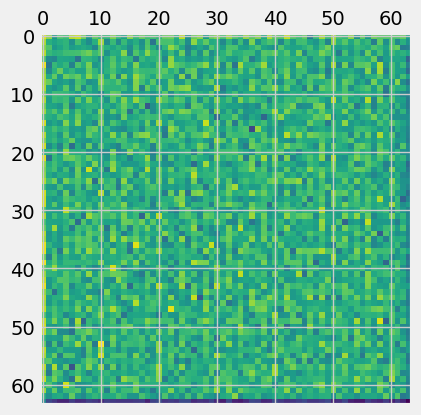

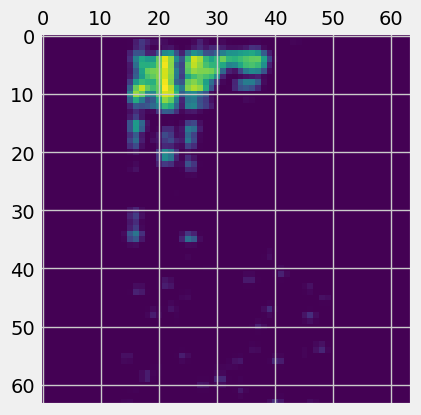

In [325]:
# Set the model to evaluation mode
model.eval()

# Make the predictions
with torch.no_grad():
    outputs = model(torch.tensor(train_data[100].reshape(1,1, 64,64)))
    
plt.matshow(outputs.reshape(64, 64)), plt.matshow(train_data[0].reshape(64, 64))

In [300]:
embeddings = []
model.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, _ = data
        # reshape the inputs and add channel dimension
        inputs = inputs.view(-1, 1, 64, 64).to(device)
        
        # forward pass
        outputs = model(inputs)
        
        # get the embeddings and store them
        embeddings.append(model.embeddings.view(inputs.size(0), -1).cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

AttributeError: 'NoneType' object has no attribute 'view'

(<matplotlib.image.AxesImage at 0x7f27c4850c70>,
 <matplotlib.image.AxesImage at 0x7f27c398ba90>)

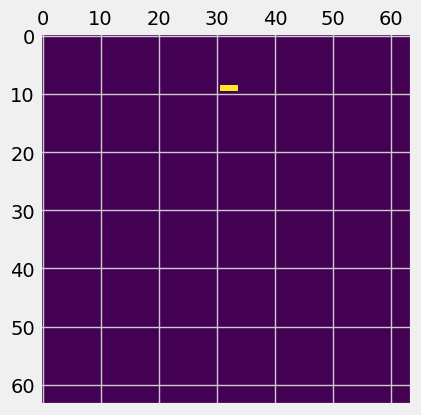

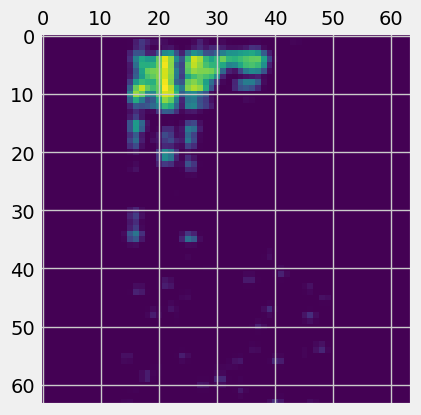